## Basics

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
df = pd.read_csv('US_Heart_Patients.csv')

In [7]:
df.head()

,Gender,age,education,currentSmoker,cigsPerDay,BP Meds,prevalentStroke,prevalentHyp,diabetes,tot cholesterol,Systolic BP,Diastolic BP,BMI,heartRate,glucose,Heart-Att
0,Male,39.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,Female,46.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,Male,48.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,Female,61.0,3.0,1.0,30.0,0.0,0.0,1.0,0.0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,Female,46.0,3.0,1.0,23.0,0.0,0.0,0.0,0.0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           4232 non-null   object 
 1   age              4238 non-null   float64
 2   education        4130 non-null   float64
 3   currentSmoker    4237 non-null   float64
 4   cigsPerDay       4209 non-null   float64
 5   BP Meds          4180 non-null   float64
 6   prevalentStroke  4231 non-null   float64
 7   prevalentHyp     4238 non-null   float64
 8   diabetes         4238 non-null   float64
 9   tot cholesterol  4180 non-null   float64
 10  Systolic BP      4236 non-null   float64
 11  Diastolic BP     4235 non-null   float64
 12  BMI              4216 non-null   float64
 13  heartRate        4236 non-null   float64
 14  glucose          3849 non-null   float64
 15  Heart-Att        4240 non-null   int64  
dtypes: float64(14), int64(1), object(1)
memory usage: 530.1+ KB


## Filling null values

In [20]:
df.isnull().sum()

Gender               0
age                  0
education            0
currentSmoker        0
cigsPerDay          31
BP Meds              0
prevalentStroke      0
prevalentHyp         0
diabetes             0
tot cholesterol     60
Systolic BP          4
Diastolic BP         5
BMI                 24
heartRate            4
glucose            391
Heart-Att            0
dtype: int64

In [18]:
df['age'].fillna(df['age'].mean(), inplace=True)

In [19]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

In [24]:
df['cigsPerDay'].fillna(df['cigsPerDay'].mean(), inplace=True)

In [25]:
df['cigsPerDay'].mean()

9.001900688999763

In [23]:
df.describe().round()

,age,education,currentSmoker,cigsPerDay,BP Meds,prevalentStroke,prevalentHyp,diabetes,tot cholesterol,Systolic BP,Diastolic BP,BMI,heartRate,glucose,Heart-Att
count,4240.0,4240.0,4240.0,4209.0,4240.0,4240.0,4240.0,4240.0,4180.0,4236.0,4235.0,4216.0,4236.0,3849.0,4240.0
mean,50.0,2.0,0.0,9.0,0.0,0.0,0.0,0.0,237.0,132.0,83.0,26.0,76.0,82.0,0.0
std,9.0,1.0,1.0,12.0,0.0,0.0,0.0,0.0,45.0,22.0,12.0,4.0,12.0,24.0,0.0
min,32.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,84.0,48.0,16.0,44.0,40.0,0.0
25%,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,117.0,75.0,23.0,68.0,71.0,0.0
50%,49.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,234.0,128.0,82.0,25.0,75.0,78.0,0.0
75%,56.0,3.0,1.0,20.0,0.0,0.0,1.0,0.0,263.0,144.0,90.0,28.0,83.0,87.0,0.0
max,70.0,4.0,1.0,70.0,1.0,1.0,1.0,1.0,696.0,295.0,142.0,57.0,143.0,394.0,1.0


In [10]:
binary_cols = ['currentSmoker', 'BP Meds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

In [11]:
for col in binary_cols:
    null_indices = df[df[col].isnull()].index
    num_nulls = len(null_indices)
    random_values = np.random.choice([0, 1], size=num_nulls)
    df.loc[null_indices, col] = random_values

In [13]:
values_to_insert = [1, 2, 3, 4]
null_indices = df[df['education'].isnull()].index
num_each_value = len(null_indices) // len(values_to_insert)
values = values_to_insert * num_each_value

In [14]:
# If there are any remaining null values, add additional values randomly
remaining_values = len(null_indices) - len(values)
if remaining_values > 0:
    values += np.random.choice(values_to_insert, remaining_values).tolist()

# Shuffle the values to insert
np.random.shuffle(values)

# Insert the values into the null positions
df.loc[null_indices, 'education'] = values

In [15]:
# Verify the changes
print(df['education'].isnull().sum())  # Should be 0
print(df['education'].value_counts())

0
education
1.0    1745
2.0    1279
3.0     716
4.0     500
Name: count, dtype: int64




This code will fill the null values in the 'education' column with the values 1, 2, 3, and 4 in equal numbers randomly.

In [16]:
cols_for_vc = ['education', 'currentSmoker', 'BP Meds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

In [ ]:
for feature in cols_for_vc:
        print(df[feature].value_counts())
        print('\n')

In [ ]:
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print(df.shape)

Number of duplicate rows = 0
(4240, 16)


In [ ]:
df['Heart-Att'].value_counts(normalize=True)

,proportion
Heart-Att,
0,0.848113
1,0.151887


In [ ]:
for feature in df.columns:
    if df[feature].dtype == 'object':
        # print(feature)
        print(df[feature].value_counts())
        print('\n')

Gender
Female    2414
Male      1818
Name: count, dtype: int64




In [ ]:
# df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df.fillna({'Gender': df['Gender'].mode}, inplace=True)

In [ ]:
df.describe().round()

,age,education,currentSmoker,cigsPerDay,BP Meds,prevalentStroke,prevalentHyp,diabetes,tot cholesterol,Systolic BP,Diastolic BP,BMI,heartRate,glucose,Heart-Att
count,4238.0,4240.0,4237.0,4209.0,4180.0,4231.0,4238.0,4238.0,4180.0,4236.0,4235.0,4216.0,4236.0,3849.0,4240.0
mean,50.0,2.0,0.0,9.0,0.0,0.0,0.0,0.0,237.0,132.0,83.0,26.0,76.0,82.0,0.0
std,9.0,1.0,1.0,12.0,0.0,0.0,0.0,0.0,45.0,22.0,12.0,4.0,12.0,24.0,0.0
min,32.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,84.0,48.0,16.0,44.0,40.0,0.0
25%,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,117.0,75.0,23.0,68.0,71.0,0.0
50%,49.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,234.0,128.0,82.0,25.0,75.0,78.0,0.0
75%,56.0,3.0,1.0,20.0,0.0,0.0,1.0,0.0,263.0,144.0,90.0,28.0,83.0,87.0,0.0
max,70.0,4.0,1.0,70.0,1.0,1.0,1.0,1.0,696.0,295.0,142.0,57.0,143.0,394.0,1.0


## Removing Outliers

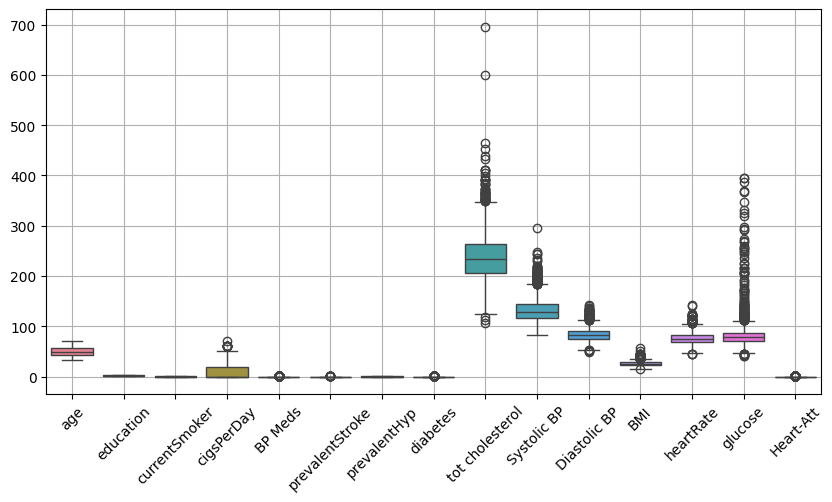

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df);
plt.grid(True)
plt.xticks(rotation=45);

In [ ]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [ ]:
for column in df.columns:
    if df[column].dtype != 'object':
        lr,ur=remove_outlier(df[column])
        df[column]=np.where(df[column]>ur,ur,df[column])
        df[column]=np.where(df[column]<lr,lr,df[column])